# Quickstart Example with Synthetic Slate Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic slate bandit feedback data.

Our example with synthetic bandit data contains the follwoing four major steps:
- (1) Synthetic Slate Data Generation
- (2) Defining Evaluation Policy
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

The second step could be replaced by some Off-Policy Learning (OPL) step, but obp still does not implement any OPL module for slate bandit data. Implementing OPL for slate bandit data is our future work.

<!-- Please see [../examples/synthetic_slate](../synthetic_slate) for a more sophisticated example of the evaluation of OPE with synthetic slate bandit data. -->

In [1]:
import numpy as np
import pandas as pd
# import open bandit pipeline (obp)
import obp

from obp.ope import SlateStandardIPS, SlateIndependentIPS, SlateRewardInteractionIPS, SlateOffPolicyEvaluation
from obp.dataset import (
    logistic_reward_function,
    SyntheticSlateBanditDataset,
)

In [2]:
from itertools import product
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# obp version
print(obp.__version__)

0.4.0


In [5]:
import warnings
warnings.filterwarnings('ignore')

## (1) Synthetic Slate Data Generation
We prepare easy-to-use synthetic slate data generator: `SyntheticSlateBanditDataset` class in the dataset module.

It takes the following arguments as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.
- length of a list of actions recommended in each slate. (`len_list`)
- number of unique actions (`n_unique_actions`)
- dimension of context vectors (`dim_context`)
- reward type (`reward_type`)
- reward structure (`reward_structure`)
- click model (`click_model`)
- base reward function (`base_reward_function`)
- behavior policy (`behavior_policy_function`)

We use a uniform random policy as a behavior policy here.

In [6]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic_reward_function` as the reward function and `linear_behavior_policy_logit` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 

n_unique_action=10
len_list = 3
dim_context = 2
reward_type = "binary"
reward_structure="cascade_additive"
click_model=None
random_state=12345
base_reward_function=logistic_reward_function

# obtain  test sets of synthetic logged bandit feedback
n_rounds_test = 10000

In [7]:
# define Uniform Random Policy as a baseline behavior policy
dataset_with_random_behavior = SyntheticSlateBanditDataset(
    n_unique_action=n_unique_action,
    len_list=len_list,
    dim_context=dim_context,
    reward_type=reward_type,
    reward_structure=reward_structure,
    click_model=click_model,
    random_state=random_state,
    behavior_policy_function=None,  # set to uniform random
    base_reward_function=base_reward_function,
)

# compute the factual action choice probabililties for the test set of the synthetic logged bandit feedback
bandit_feedback_with_random_behavior = dataset_with_random_behavior.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_test,
    return_pscore_item_position=True,
)

# print policy value
random_policy_value = dataset_with_random_behavior.calc_on_policy_policy_value(
    reward=bandit_feedback_with_random_behavior["reward"],
    slate_id=bandit_feedback_with_random_behavior["slate_id"],
)
print(random_policy_value)

[sample_action_and_obtain_pscore]: 100%|██████████| 10000/10000 [00:01<00:00, 6149.51it/s]

1.8366


## (2) Evaluation Policy Definition (Off-Policy Learning)
 After generating synthetic data, we now define the evaluation policy as follows:
 
1. Generate logit values of three valuation policies (`random`, `optimal`, and `anti-optimal`).
  - A `optimal` policy is defined by a policy that samples actions using`3 * base_expected_reward`.
  - An `anti-optimal` policy is defined by a policy that samples actions using the sign inversion of `-3 * base_expected_reward`.
2. Obtain pscores of the evaluation policies by `obtain_pscore_given_evaluation_policy_logit` method.

In [8]:
random_policy_logit_ = np.zeros((n_rounds_test, n_unique_action))

In [9]:
base_expected_reward = dataset_with_random_behavior.base_reward_function(
    context=bandit_feedback_with_random_behavior["context"],
    action_context=dataset_with_random_behavior.action_context,
    random_state=dataset_with_random_behavior.random_state,
)

In [10]:
optimal_policy_logit_ = base_expected_reward * 3
anti_optimal_policy_logit_ = -3 * base_expected_reward

In [11]:
random_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=random_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:09<00:00, 1037.09it/s]


In [12]:
optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:10<00:00, 995.15it/s]


In [13]:
anti_optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:10<00:00, 996.97it/s]


## (3) Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use the **SlateStandardIPS (SIPS)**, **SlateIndependentIPS (IIPS)**, and **SlateRewardInteractionIPS (RIPS)** estimators and visualize the OPE results.

In [14]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=len_list)
iips = SlateIndependentIPS(len_list=len_list)
rips = SlateRewardInteractionIPS(len_list=len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback_with_random_behavior,
    ope_estimators=[sips, iips, rips]
)

          mean  95.0% CI (lower)  95.0% CI (upper) policy_name
sips  1.836816            1.8205          1.852505      random
iips  1.836816            1.8205          1.852505      random
rips  1.836816            1.8205          1.852505      random 



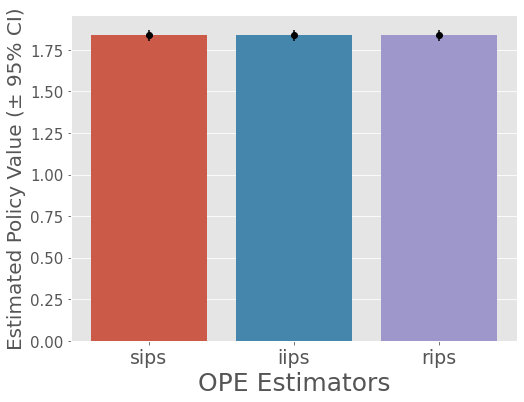

In [15]:
_, estimated_interval_random = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_random["policy_name"] = "random"

print(estimated_interval_random, '\n')
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

          mean  95.0% CI (lower)  95.0% CI (upper) policy_name
sips  1.830555          1.803695          1.860548     optimal
iips  1.843117          1.825576          1.859695     optimal
rips  1.838866          1.815574          1.862451     optimal 



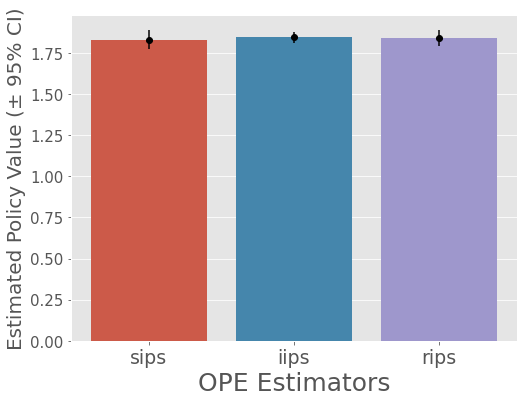

In [16]:
_, estimated_interval_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)

estimated_interval_optimal["policy_name"] = "optimal"

print(estimated_interval_optimal, '\n')
# visualize estimated policy values of Optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

          mean  95.0% CI (lower)  95.0% CI (upper)   policy_name
sips  1.854516          1.829643          1.877320  anti-optimal
iips  1.832793          1.815842          1.848599  anti-optimal
rips  1.844397          1.824965          1.864795  anti-optimal 



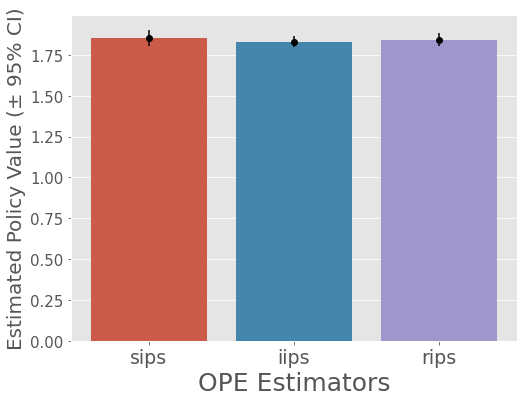

In [17]:
_, estimated_interval_anti_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_anti_optimal["policy_name"] = "anti-optimal"

print(estimated_interval_anti_optimal, '\n')
# visualize estimated policy values of Anti-optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic slate data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turths to evaluate the accuracy of OPE.

In [18]:
ground_truth_policy_value_random = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=random_policy_logit_
)
ground_truth_policy_value_random

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:04<00:00, 2268.03it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


1.837144428308276

In [19]:
ground_truth_policy_value_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=optimal_policy_logit_
)
ground_truth_policy_value_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:04<00:00, 2177.17it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


1.8474242800908984

In [20]:
ground_truth_policy_value_anti_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)
ground_truth_policy_value_anti_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:04<00:00, 2176.73it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


1.8352871486686428

In [21]:
estimated_interval_random["ground_truth"] = ground_truth_policy_value_random
estimated_interval_optimal["ground_truth"] = ground_truth_policy_value_optimal
estimated_interval_anti_optimal["ground_truth"] = ground_truth_policy_value_anti_optimal

estimated_intervals = pd.concat(
    [
        estimated_interval_random,
        estimated_interval_optimal,
        estimated_interval_anti_optimal
    ]
)

In [22]:
estimated_intervals

,mean,95.0% CI (lower),95.0% CI (upper),policy_name,ground_truth
sips,1.836816,1.820500,1.852505,random,1.837144
iips,1.836816,1.820500,1.852505,random,1.837144
rips,1.836816,1.820500,1.852505,random,1.837144
sips,1.830555,1.803695,1.860548,optimal,1.847424
iips,1.843117,1.825576,1.859695,optimal,1.847424
rips,1.838866,1.815574,1.862451,optimal,1.847424
sips,1.854516,1.829643,1.877320,anti-optimal,1.835287
iips,1.832793,1.815842,1.848599,anti-optimal,1.835287
rips,1.844397,1.824965,1.864795,anti-optimal,1.835287


We can confirm that the three OPE estimators return the same results when the behavior policy and the evaluation policy is the same, and the estimates are quite similar to the `random_policy_value` calcurated above.

We can also observe that the performance of OPE estimators are as follows in this simulation: `IIPS > RIPS > SIPS`.

In [23]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_random_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_random,
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
)
relative_ee_for_random_evaluation_policy

,relative-ee
sips,0.000296
iips,0.000296
rips,0.000296


In [24]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_optimal,
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
)
relative_ee_for_optimal_evaluation_policy

,relative-ee
sips,0.009303
iips,0.002470
rips,0.004732


In [25]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_anti_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_anti_optimal,
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
)
relative_ee_for_anti_optimal_evaluation_policy

,relative-ee
sips,0.010281
iips,0.001506
rips,0.004751


The variance of OPE estimators is as follows: `SIPS > RIPS > IIPS`.

In [26]:
estimated_intervals["errbar_length"] = (
    estimated_intervals.drop(["mean", "policy_name", "ground_truth"], axis=1).diff(axis=1).iloc[:, -1].abs()
)

(1.7, 1.9)

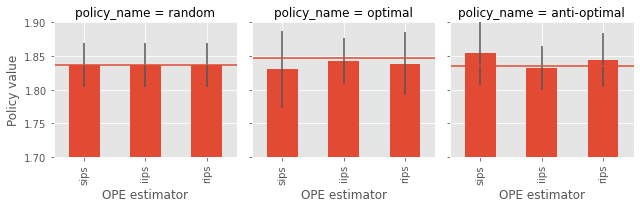

In [27]:
alpha = 0.05
plt.style.use("ggplot")

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
    ax.hlines(data["ground_truth"].iloc[0], -1, len(x)+1)
#     ax.set_xlabel("OPE estimator")
    
g = sns.FacetGrid(
    estimated_intervals.reset_index().rename(columns={"index": "OPE estimator", "mean": "Policy value"}),
    col="policy_name"
)
g.map_dataframe(errplot, "OPE estimator", "Policy value", "errbar_length")
plt.ylim((1.7, 1.9))

It is surprising that `RIPS` estimator does not achieve the best performance even if the reward structure is not independent. If we run a simulation where the reward of each position depends heavily on those of other positions, `RIPS`estimator could achieve the best performance.
<!-- Please see [../examples/synthetic_slate](../synthetic_slate) for a more sophisticated example of the evaluation of OPE with synthetic slate bandit data. -->